/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 001: val_loss = 0.5798, val_accuracy = 0.8233
Epoch 002: val_loss = 0.4869, val_accuracy = 0.8833
Epoch 003: val_loss = 0.4105, val_accuracy = 0.9100
Epoch 004: val_loss = 0.3440, val_accuracy = 0.9233
Epoch 005: val_loss = 0.2863, val_accuracy = 0.9300
Epoch 006: val_loss = 0.2449, val_accuracy = 0.9333
Epoch 007: val_loss = 0.2158, val_accuracy = 0.9400
Epoch 008: val_loss = 0.1934, val_accuracy = 0.9400
Epoch 009: val_loss = 0.1767, val_accuracy = 0.9467
Epoch 010: val_loss = 0.1631, val_accuracy = 0.9500
Epoch 011: val_loss = 0.1542, val_accuracy = 0.9500
Epoch 012: val_loss = 0.1484, val_accuracy = 0.9567
Epoch 013: val_loss = 0.1436, val_accuracy = 0.9533
Epoch 014: val_loss = 0.1398, val_accuracy = 0.9533
Epoch 015: val_loss = 0.1365, val_accuracy = 0.9533
Epoch 016: val_loss = 0.1337, val_accuracy = 0.9567
Epoch 017: val_loss = 0.1302, val_accuracy = 0.9600
Epoch 018: val_loss = 0.1269, val_accuracy = 0.9567
Epoch 019: val_loss = 0.1247, val_accuracy = 0.9567
Epoch 020: v

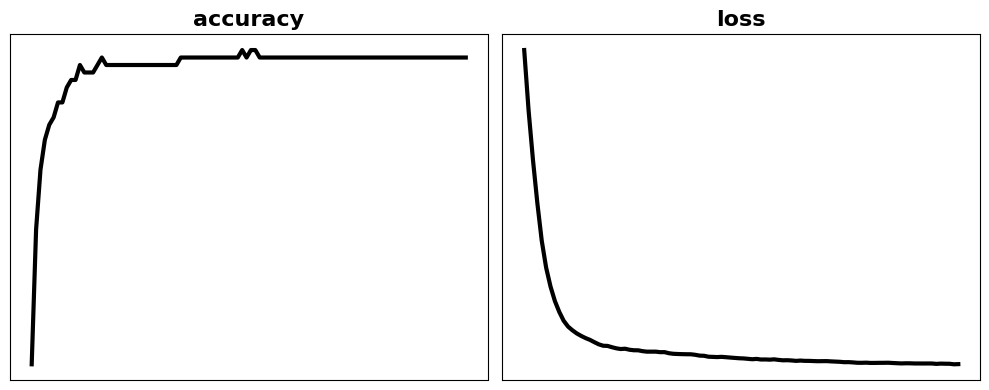


✅ Final Accuracy: 0.9600
✅ Final Loss: 0.0964


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Step 1: Generate and preprocess the data
X, y = make_classification(n_samples=1500, n_features=20, n_informative=15, n_redundant=5,
                           n_classes=2, random_state=42)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Enhanced model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Step 3: Nadam parameters
learning_rate = 0.0005
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-7

# Initialize optimizer variables
m = [tf.Variable(tf.zeros_like(var), trainable=False) for var in model.trainable_variables]
v = [tf.Variable(tf.zeros_like(var), trainable=False) for var in model.trainable_variables]
loss_fn = tf.keras.losses.BinaryCrossentropy()

val_acc_metric = tf.keras.metrics.BinaryAccuracy()

epochs = 100
batch_size = 32
steps_per_epoch = X_train.shape[0] // batch_size
history = {'val_loss': [], 'val_accuracy': []}

# Step 4: Training loop
for epoch in range(epochs):
    idx = np.random.permutation(len(X_train))
    X_train = X_train[idx]
    y_train = y_train[idx]

    for step in range(steps_per_epoch):
        start = step * batch_size
        end = start + batch_size
        x_batch = X_train[start:end]
        y_batch = y_train[start:end]

        with tf.GradientTape() as tape:
            y_pred = model(x_batch, training=True)
            loss = loss_fn(y_batch, y_pred)

        grads = tape.gradient(loss, model.trainable_variables)

        t = epoch * steps_per_epoch + step + 1
        lr_t = learning_rate / (1. + 0.01 * t)  # Decaying learning rate

        for i, (grad, var) in enumerate(zip(grads, model.trainable_variables)):
            m[i].assign(beta1 * m[i] + (1 - beta1) * grad)
            v[i].assign(beta2 * v[i] + (1 - beta2) * tf.square(grad))

            m_hat = m[i] / (1 - beta1 ** t)
            v_hat = v[i] / (1 - beta2 ** t)

            nesterov_m = beta1 * m_hat + ((1 - beta1) * grad / (1 - beta1 ** t))
            var.assign_sub(lr_t * nesterov_m / (tf.sqrt(v_hat) + epsilon))

    # Validation
    y_val_pred = model(X_test, training=False)
    val_loss = loss_fn(y_test, y_val_pred).numpy()
    val_acc_metric.update_state(y_test, y_val_pred)
    val_accuracy = val_acc_metric.result().numpy()
    val_acc_metric.reset_state()

    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    print(f"Epoch {epoch+1:03d}: val_loss = {val_loss:.4f}, val_accuracy = {val_accuracy:.4f}")

# Step 5: Plotting
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history['val_accuracy'], color='black', linewidth=3)
plt.title('accuracy', fontsize=16, weight='bold')
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
plt.plot(history['val_loss'], color='black', linewidth=3)
plt.title('loss', fontsize=16, weight='bold')
plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()

# Step 6: Final Accuracy and Loss
final_y_pred = model(X_test, training=False)
final_loss = loss_fn(y_test, final_y_pred).numpy()

final_accuracy_metric = tf.keras.metrics.BinaryAccuracy()
final_accuracy_metric.update_state(y_test, final_y_pred)
final_accuracy = final_accuracy_metric.result().numpy()

print(f"\n✅ Final Accuracy: {final_accuracy:.4f}")
print(f"✅ Final Loss: {final_loss:.4f}")
